In [4]:
from tqdm.notebook import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from varname import nameof
# from qutip import *
from itertools import product
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
import time
import functools
from scipy import special
import scipy
from IPython.display import display, clear_output
from fermionise import *


plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")

D0 = 1
deltaD = 0.001
plt.plot([], [])
plt.show()
clear_output()

In [5]:
def get_RG_flow(J0_by_D0, Ub_by_J=0, plot=False):
    """ Returns the flow of couplings in the form of two ndarrays J and D.
    Each ndarray is in ascending order of the bandwidth. """
    J0 = D0 * J0_by_D0
    Ub = - Ub_by_J * J0
    omega = -D0/2
    
    ### initialise arrays with UV values
    D = [D0]
    J = [J0]
    
    ### apply URG transformations until bandwith vanishes
    ### or J reduces to zero.
    while D[-1] >= deltaD and J[-1] >= 0:
        
        ### URG equation
        deltaJ = - J[-1] * (J[-1] + 4 * Ub) / (omega - D[-1]/2 + J[-1]/4) * deltaD
        
        ### Check if denominator has changed sign, 
        ### then append renormalised values to array
        if (omega - (D[-1] - deltaD)/2 + (J[-1] + deltaJ)/4) * (omega - D0/2 + J0/4) > 0:
            D.append(D[-1] - deltaD)
            J.append(J[-1] + deltaJ)
        else:
            break
    
    ### plot values
    if plot:
        plt.plot(np.array(D)/D0, np.array(J)/J0, marker="o")
        plt.xlabel(r"$D/D_0$")
        plt.ylabel(r"$J/J_0$")
    return np.flip(D), np.flip(J)

G-state energy: [-0.08097531]
↓|0|0|↑		↓|0|↑|0		↓|↑|0|0		↑|0|0|↓		↑|0|↓|0		↑|↓|0|0
0.334		0.395		0.482		-0.334		-0.395		-0.482


Applying inverse unitaries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.39it/s]


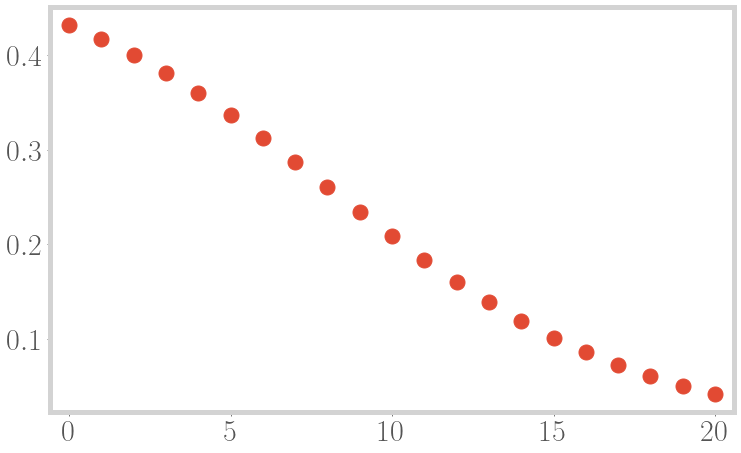

In [10]:
def KondoMERG():
    D, J = get_RG_flow(0.05)
    omega = -D0/2
    num_entangled = 3
    num_IOMs = 20
    Ek = np.linspace(0, 0.01 * num_entangled, num_entangled)
    init_couplings = [Ek, J[0], 0]
    alpha_arr = [Ji / (2 * (omega - Di/2 + Ji/4)) for Ji, Di in zip(J, D)]
    coefficients_arr, combinations_arr = getWavefunctionRG(init_couplings, alpha_arr, num_entangled, num_IOMs, getEtaKondo)
    computation_results = computations(coefficients_arr, combinations_arr, [["I2", [[0, 1], [4, 5]]]])
    plt.plot(computation_results["I2"], 'o')
    
KondoMERG()

1000 1000.0
Starting with 6 k-states in the bath.
-0.009952373589718922


  0%|          | 0/128 [00:00<?, ?it/s]

Applying inverse unitaries:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

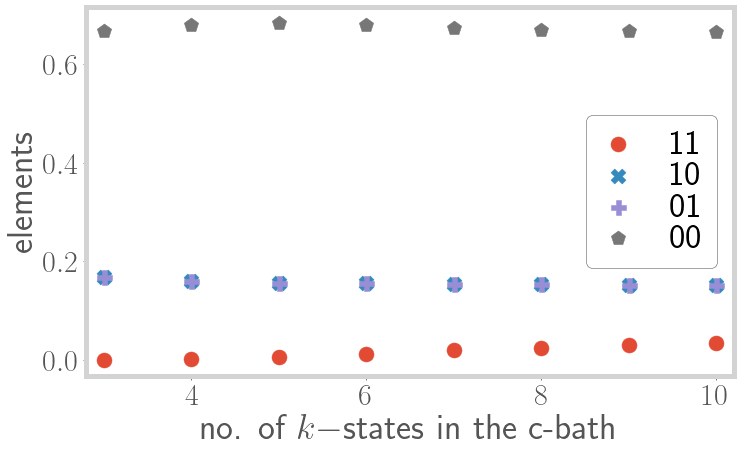

  0%|          | 0/8 [00:00<?, ?it/s]

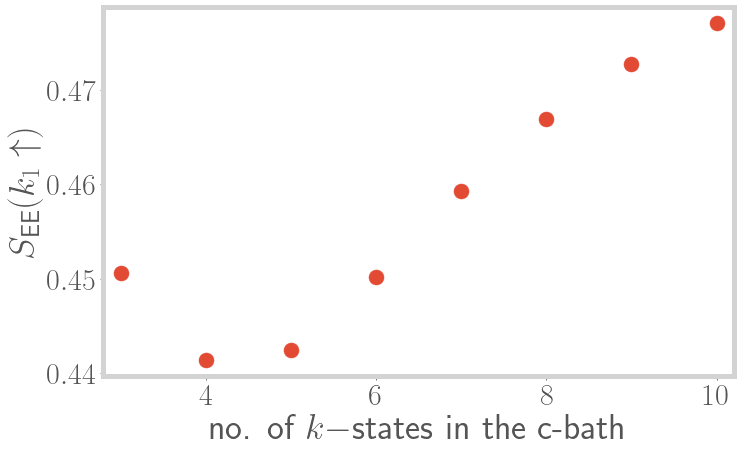

  0%|          | 0/8 [00:00<?, ?it/s]

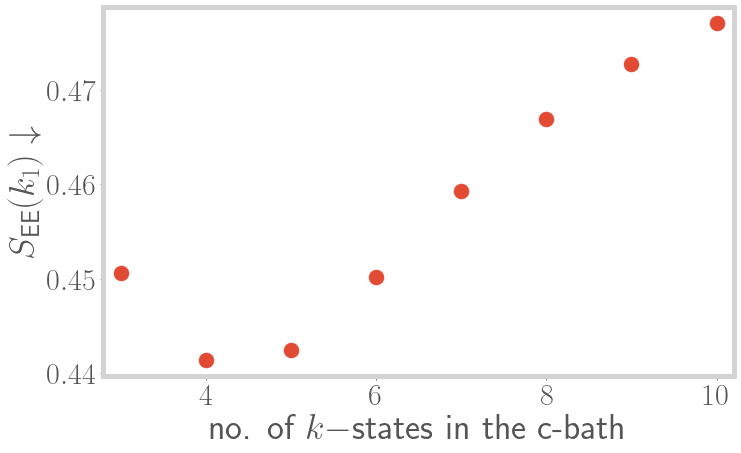

In [8]:
computations = get_tensorRG(0.1, 3, 7, ['h', 'p'], [
    ['elements_rhok', [1, 2], r"elements", "rhok.pdf"],
    ['VNE', [1], r"$S_\text{EE}(k_1\uparrow)$", "VNE_kup.pdf"],
    ['VNE', [2], r"$S_\text{EE}(k_1)\downarrow$", "VNE_kdn.pdf"],
])

## **Benchmarks against a more "brute-force" approach**

In [ ]:
def bruteForceMERG(J0_by_D0, num_in, num_out):
    omega = -D0/2
    num_in_start = num_in
    D, J = get_RG_flow(J0_by_D0)
    assert len(J) >= num_out + 1
    total_dim = 1 + 2 * (num_in + num_out)
    c_all = [tensor([identity(2)] + [sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 2)) for i in range(total_dim - 1)]
    Sdz = 0.5 * tensor([sigmaz()] +  [identity(2)] * (total_dim - 1))
    Sdp = tensor([sigmap()] +  [identity(2)] * (total_dim - 1))
    Sdm = Sdp.dag()
    vacuum = tensor([basis(2,0)]*total_dim)
    init_state = 0
    for k_pos in range(0, 2 * num_in, 2):
        init_state += c_all[k_pos + 1].dag() * vacuum
        init_state += - Sdm * c_all[k_pos].dag() * vacuum
    gstates = [init_state.unit()]
    ref_state1 = c_all[3].dag() * vacuum
    ref_state2 = Sdm * c_all[2].dag() * vacuum
    ref_state3 = c_all[5].dag() * vacuum
    ref_state4 = Sdm * c_all[4].dag() * vacuum
    ref_state5 = Sdm * c_all[0].dag() * vacuum
    ref_state6 = c_all[1].dag() * vacuum

    for Ji, Eq in tqdm(zip(J[1:num_out+1], D[1:num_out+1]), total=num_out):
        q_pos = 2 * num_in
        alpha = Ji / (omega - Eq/2 + Ji/4)
        eta = 0
        eta_dag = 0
        for k_pos in range(0, q_pos, 2):
            for beta in [1, -1]:
                beta_pos = 0 if beta == 1 else 1
                eta += alpha * Sdz * beta * c_all[k_pos + beta_pos].dag() * c_all[q_pos + beta_pos]
                eta += alpha * [Sdp, Sdm][beta_pos] * c_all[k_pos + 1 - beta_pos].dag() * c_all[q_pos + beta_pos]
                eta_dag += alpha * Sdz * beta * c_all[q_pos + beta_pos].dag() * c_all[k_pos + beta_pos]
                eta_dag += alpha * [Sdp, Sdm][1 - beta_pos] * c_all[q_pos + beta_pos].dag() * c_all[k_pos + 1 - beta_pos]
        gstates.append(((1 + eta + eta_dag) * gstates[-1]).unit())

        num_in += 1
    
    vne_arr = []
    I2_arr = []
    for state in tqdm(gstates):
        rho = state * state.dag().unit()
        rho_k = rho.ptrace([1])
        rho_d = rho.ptrace([0])
        rho_dk = rho.ptrace([0, 1])
        SEE_k = entropy_vn(rho_k)
        SEE_d = entropy_vn(rho_d)
        SEE_dk = entropy_vn(rho_dk)
        I2_dk = SEE_k + SEE_d - SEE_dk
        vne_arr.append(SEE_k)
        I2_arr.append(I2_dk)                   
    print (vne_arr)
    print (I2_arr)

    computations = get_tensorRG(J0_by_D0, num_in_start, num_out + 5, [['VNE', [1], r"$S_\text{EE}(k_1)$", "VNE_k.pdf"],
                                                                      ['I2', [[0], [1]], r"$I_2(d:k_1)$", "I2_dk.pdf"]])
    plt.scatter(range(num_in_start, num_in_start + num_out + 1), vne_arr, color=cols[1], zorder=99, label="slower approach")
    plt.plot(range(num_in_start, num_in_start + len(computations['VNE'])), computations['VNE'], label="faster approach")
    plt.ylabel(r"$S_\text{{EE}}(k)$")
    plt.xlabel(r"no. of $k-$states in the c-bath")
    plt.text(0.2, 0.2, r"$n_\text{{IR}}={:.0f}$".format(num_in_start), bbox=bbox, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.savefig("comparison_VNE_{:.0f}.pdf".format(num_in_start), bbox_inches='tight')
    plt.show()
    plt.scatter(range(num_in_start, num_in_start + num_out + 1), I2_arr, color=cols[1], zorder=99, label="slower approach")
    plt.plot(range(num_in_start, num_in_start + len(computations['I2'])), computations['I2'], label="faster approach")
    plt.ylabel(r"$I_2(d:k)$")
    plt.xlabel(r"no. of $k-$states in the c-bath")
    plt.text(0.2, 0.2, r"$n_\text{{IR}}={:.0f}$".format(num_in_start), bbox=bbox, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.savefig("comparison_I2_{:.0f}.pdf".format(num_in_start), bbox_inches='tight')
    plt.show()

bruteForceMERG(0.1, 1, 6)
bruteForceMERG(0.1, 3, 4)